<a href="https://colab.research.google.com/github/AmineBAA/Deep-Insights_Neural-Network/blob/main/TCAV_CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCAV for CIFAR10

## 1. Libraries

In [1]:
pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.8 MB/s eta 0:00:00


In [2]:
from captum.concept._core.concept import Concept, ConceptInterpreter

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7675904008419236714
 xla_global_id: -1]

In [4]:
!git clone https://github.com/pnxenopoulos/cav-keras.git
!cp -R cav-keras/cav cav/

Cloning into 'cav-keras'...
remote: Enumerating objects: 369, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 369 (delta 1), reused 0 (delta 0), pack-reused 363
Receiving objects: 100% (369/369), 23.58 MiB | 30.91 MiB/s, done.
Resolving deltas: 100% (161/161), done.


In [5]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.datasets import cifar100, cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

from cav.tcav import *

np.random.seed(1996)

## 2. Dataset

In [79]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Keep ships (8) from CIFAR-10
interested_class = y_train == [43]
interested_class_indx = [i for i, x in enumerate(interested_class) if x]
x_train_class_one = x_train[interested_class_indx]
other = y_train == [2]
other_indx = [i for i, x in enumerate(other) if x]
x_train_class_two = x_train[other_indx]

x_train = np.append(x_train_class_one, x_train_class_two, axis = 0)
y_train = [1] * 500
y_train = y_train + [0] * 500

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

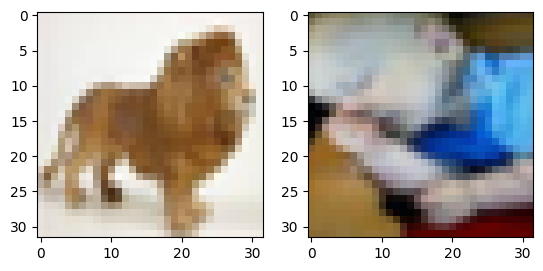

In [80]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[5])
axarr[1].imshow(x_train[600])

In [66]:
(x_train_concept, y_train_concept), (x_test_concept, y_test_concept) = cifar100.load_data()

# keep sea (71) from CIFAR-100
concept = y_train_concept == [71]
indices = concept
indx_to_use = [i for i, x in enumerate(indices) if x]

x_train_concept = x_train_concept[indx_to_use]

In [67]:
x_train.shape

(1000, 32, 32, 3)

In [ ]:
### Import concept dataset

In [81]:
import torchvision
from torchvision import models
from torchvision import transforms
import torch
import torch.nn.functional as F

from PIL import Image

import pandas as pd

In [27]:
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(32),
 transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
     mean=[0.485, 0.456, 0.406],
     std=[0.229, 0.224, 0.225]
 )

img = Image.open('/content/Fourure_10.jpg')

transformed_img = transform(img)

input = transform_normalize(transformed_img)
input = input.unsqueeze(0)

In [10]:
#x_train_concept=input

In [28]:
x_train_concept = np.append(x_train_concept, input, axis = 0)

In [29]:
x_train_concept.shape

(10, 3, 32, 32)

In [30]:
x_train.shape

(1000, 32, 32, 3)

In [31]:
x_train_concept0=np.transpose(x_train_concept[0,])
x_train_concept1=np.transpose(x_train_concept[1,])
x_train_concept2=np.transpose(x_train_concept[2,])
x_train_concept3=np.transpose(x_train_concept[3,])
x_train_concept4=np.transpose(x_train_concept[4,])
x_train_concept5=np.transpose(x_train_concept[5,])
x_train_concept6=np.transpose(x_train_concept[6,])
x_train_concept7=np.transpose(x_train_concept[7,])
x_train_concept8=np.transpose(x_train_concept[8,])
x_train_concept9=np.transpose(x_train_concept[9,])

In [ ]:
x_train_concept0.shape

(32, 32, 3)

In [32]:
x_train_concept_smoothed=np.stack((x_train_concept0,
                                   x_train_concept1,
                                   x_train_concept2,
                                   x_train_concept3,
                                   x_train_concept4,
                                   x_train_concept5,
                                   x_train_concept6,
                                   x_train_concept7,
                                   x_train_concept8,
                                   x_train_concept9
                                   ), axis=0)

In [45]:
x_train_concept_smoothed.shape

(10, 32, 32, 3)

## 3. Model setup

In [82]:
batch_size = 32
epochs = 10

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# initiate optimizer
opt = keras.optimizers.legacy.Adam(learning_rate=0.001)

# train the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])



In [83]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [84]:
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)

Train on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 5s 5ms/sample - loss: 0.6907 - accuracy: 0.5420
Epoch 2/10
1000/1000 [==============================] - 6s 6ms/sample - loss: 0.5887 - accuracy: 0.7120
Epoch 3/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.5045 - accuracy: 0.7710
Epoch 4/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.4724 - accuracy: 0.7960
Epoch 5/10
1000/1000 [==============================] - 6s 6ms/sample - loss: 0.4493 - accuracy: 0.7880
Epoch 6/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.4575 - accuracy: 0.7860
Epoch 7/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.3693 - accuracy: 0.8460
Epoch 8/10
1000/1000 [==============================] - 6s 6ms/sample - loss: 0.4256 - accuracy: 0.8260
Epoch 9/10
1000/1000 [==============================] - 4s 4ms/sample - loss: 0.3866 - accuracy: 0.8350
Epoch 10/10
1000/1000 [===================

In [ ]:
model.summary()

In [ ]:
dir(model)

In [87]:
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

layer_name = 'conv2d_10'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

grads = K.gradients(loss, model.input)[0]

## 4. TCAV

In [88]:
mymodel=model

In [89]:
tcav_obj = TCAV()
tcav_obj.set_model(mymodel)

In [72]:
# Define the concepts
x_train_concept_smoothed = np.array(x_train_concept_smoothed)

In [90]:
tcav_obj.split_model(bottleneck = 0, conv_layer = True)
tcav_obj.train_cav(x_train_concept_smoothed)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [91]:
tcav_obj.calculate_sensitivity(x_train, y_train)
tcav_obj.print_sensitivity()

The sensitivity of class 1 is  0.858
The sensitivity of class 0 is  0.234
